## 1. Dependencies and Libraries

In [1]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asgiref                      3.8.1
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
Django                       4.2.11
exceptiongroup               1.2.

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

## 2. Load the data

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
img_data = tf.keras.utils.image_dataset_from_directory('../datasets/fire_data')

Found 1000 files belonging to 2 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

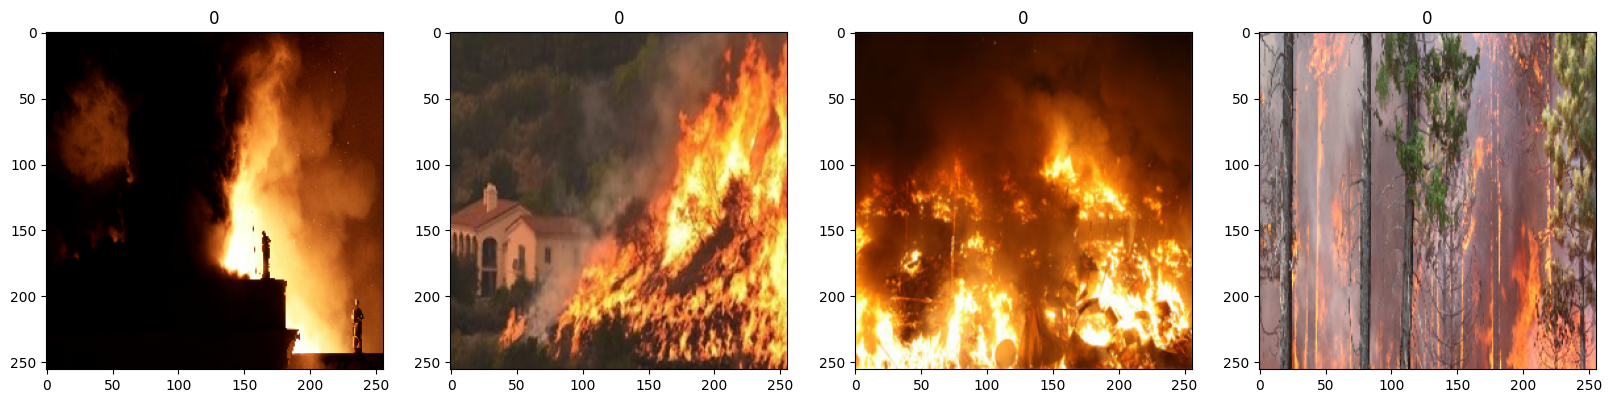

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 3. Scale the images

In [21]:
img_data = img_data.map(lambda x, y:(x/255, y))

In [22]:
img_data.as_numpy_iterator().next()

(array([[[[4.24959302e-01, 5.37332356e-01, 4.09112185e-01],
          [4.72989678e-01, 6.02986395e-01, 4.29302126e-01],
          [5.37183940e-01, 6.49557650e-01, 4.32968199e-01],
          ...,
          [1.49870396e-01, 3.40468705e-01, 1.89893171e-01],
          [1.81000829e-01, 2.39928007e-01, 2.33611107e-01],
          [1.43672332e-01, 2.52874166e-01, 1.15242273e-01]],
 
         [[5.23638666e-01, 6.84604049e-01, 4.76233631e-01],
          [5.05702972e-01, 6.49072647e-01, 4.40126538e-01],
          [4.83192831e-01, 5.84146798e-01, 3.70682657e-01],
          ...,
          [1.76197603e-01, 5.07028043e-01, 1.92757875e-01],
          [1.94410622e-01, 3.44648659e-01, 2.16522574e-01],
          [1.37415275e-01, 3.88077080e-01, 8.60955939e-02]],
 
         [[4.88356650e-01, 6.43034220e-01, 3.88970822e-01],
          [3.83763939e-01, 5.13999283e-01, 2.85591155e-01],
          [3.21794212e-01, 3.64179909e-01, 1.96812287e-01],
          ...,
          [1.77821144e-01, 4.82874602e-01, 1.7975

## 4. Split into training, test, and val data

In [27]:
train_size = int(len(img_data)*.64)
test_size = int(len(img_data)*.2)
val_size = int(len(img_data)*.16)

In [28]:
train_size

20

In [29]:
test_size

6

In [30]:
val_size

5

In [31]:
train_data = img_data.take(train_size)
val_data = img_data.skip(train_size).take(val_size)
test_data = img_data.skip(train_size + val_size).take(test_size)

## 5. Build the neural network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [34]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

P:\Projects\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training

In [38]:
logdir = 'logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.6596 - loss: 0.7266 - val_accuracy: 0.9125 - val_loss: 0.2397
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.9093 - loss: 0.2258 - val_accuracy: 0.9125 - val_loss: 0.1685
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9491 - loss: 0.1491 - val_accuracy: 0.9438 - val_loss: 0.1779
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.9353 - loss: 0.1468 - val_accuracy: 0.9812 - val_loss: 0.0893
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.9797 - loss: 0.0701 - val_accuracy: 0.9375 - val_loss: 0.1721
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.9772 - loss: 0.0761 - val_accuracy: 0.9688 - val_loss: 0.1147
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.9820 - loss: 0.0467 - val_accuracy: 0.9625 - val_loss: 0.0882
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.9868 - loss: 0.0461 - val_accuracy: 0

## 7. Plot the Metrics

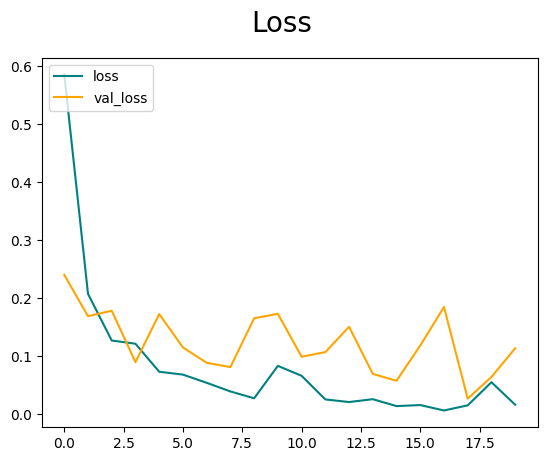

In [42]:
# Loss plot

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

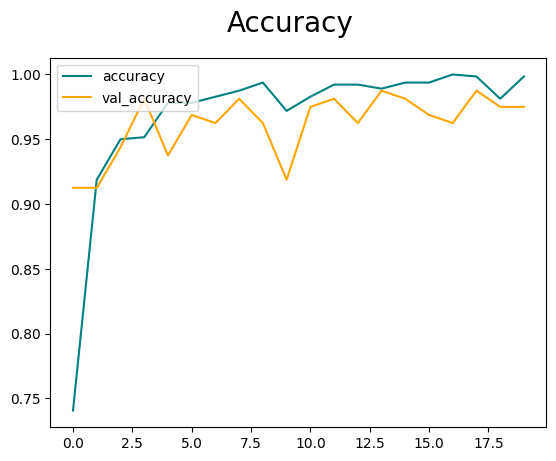

In [43]:
# Accuracy plot
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 8. Evaluating the Results

In [44]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
precision_res = Precision()
recall_res = Recall()
accuracy_res = BinaryAccuracy()

In [48]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    pred = model.predict(X)
    precision_res.update_state(y, pred)
    recall_res.update_state(y, pred)
    accuracy_res.update_state(y, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [50]:
print(f'Precision: {precision_res.result()}\nRecall: {recall_res.result()}\nAccuracy: {accuracy_res.result()}')

Precision: 0.925000011920929
Recall: 0.9487179517745972
Accuracy: 0.9739583134651184
